# 주요 관광명소들의 인기변화
- 2021년 기준 '한국관광 데이터랩' 사이트에서 관광명소 자료를 받아와서, 구글트렌드에서 인기변화를 살펴본다. 

In [26]:
# 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

# Matplotlib 한글 폰트 설정
from matplotlib import font_manager as fm, rc

# 한글 폰트 설정
font_path = './font/malgun.ttf'
font_name = fm.FontProperties(fname = font_path).get_name()
rc('font', family = font_name)



import folium

In [27]:
# 경로 설정
PATH = './Data/'


In [28]:
# csv -> 데이터프레임
tourdf = pd.read_csv(PATH + '20220711164757_toursearchrank.csv', encoding='cp949', index_col= '순위')
tourdf

,시도명,관광지명,주소,중분류,소분류,검색건수
순위,,,,,,
1,경기도,스타필드하남,경기 하남시 미사대로 750-0,쇼핑,쇼핑몰,1337321
2,경기도,스타필드고양,경기 고양시 덕양구 고양대로 1955-0,쇼핑,쇼핑몰,999151
3,경기도,에버랜드,경기 용인시 처인구 에버랜드로 199-0,문화관광,테마공원,871570
4,강원도,속초관광수산시장,강원 속초시 중앙로147번길 16-0,쇼핑,시장,770302
5,경기도,현대프리미엄아울렛김포점,경기 김포시 아라육로152번길 100-0,쇼핑,쇼핑몰,769836
...,...,...,...,...,...,...
96,서울특별시,남산서울타워,서울 용산구 남산공원길 105-0,문화관광,랜드마크관광,178868
97,강원도,낙산사,강원 양양군 낙산사로 100-0,역사관광,종교성지,178713
98,경기도,안양농수산물도매시장,경기 안양시 동안구 흥안대로 313-0,쇼핑,시장,176675


In [29]:
# 데이터프레임 정보탐색
tourdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 100
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시도명     100 non-null    object
 1   관광지명    100 non-null    object
 2   주소      100 non-null    object
 3   중분류     100 non-null    object
 4   소분류     100 non-null    object
 5   검색건수    100 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 5.5+ KB


In [30]:
# 데이터프레임의 고유값 탐색
print(tourdf['중분류'].unique())
print(tourdf['소분류'].unique())
print(tourdf['중분류'].value_counts())
print(tourdf['소분류'].value_counts())

['쇼핑' '문화관광' '자연관광' '역사관광' '숙박' '음식' '기타관광']
['쇼핑몰' '테마공원' '시장' '전시시설' '자연경관(하천/해양)' '도시공원' '랜드마크관광' '역사유적지' '공연시설'
 '복합관광시설' '콘도미니엄' '종교성지' '기타음식' '기타관광' '호텔' '자연경관(산)']
쇼핑      45
문화관광    21
자연관광    18
숙박       6
역사관광     5
기타관광     4
음식       1
Name: 중분류, dtype: int64
쇼핑몰            31
자연경관(하천/해양)    17
시장             14
도시공원            9
테마공원            5
기타관광            4
호텔              4
전시시설            3
역사유적지           3
랜드마크관광          2
콘도미니엄           2
종교성지            2
공연시설            1
복합관광시설          1
기타음식            1
자연경관(산)         1
Name: 소분류, dtype: int64


### 항목은 소분류를 기본으로 하되, 개수가 너무 많기 때문에 
- 기타관광~기타음식 값을 기타라는 항목으로 통합하고, 자연경관(산)과 자연경관(하천/해양)은 통합

In [31]:
# 자연경관(산)과 자연경관(하천/해양)은 통합
# 자연경관(산)인 값 찾기
# mountain = list(tourdf.index[tourdf['소분류'] == '자연경관(산)'])
# tourdf.loc[mountain, '소분류'] = "자연경관"
tourdf.loc[['(' in index for index in tourdf['소분류']], '소분류'] = '자연경관'

# 기타관광~기타음식 -> 기타라는 항목으로 통합
del_list = list(tourdf['소분류'].value_counts().index[5:15])
cond = tourdf['소분류'].isin(del_list)
tourdf.loc[cond, '소분류'] = '기타'

# 잘 작동했는지 체크
our_list = list(tourdf['소분류'].unique())
our_list

['쇼핑몰', '테마공원', '시장', '기타', '자연경관', '도시공원']

In [32]:
def makecond(search, col, df):
    """
    search -> 원하는 값, col -> 컬럼명, df -> DataFrame, return: 조건에 맞는 DataFrame
    """
    cond = df[col] == search
    return df[cond].head(15)
    
# 소분류에서 상위 5개의 항목 ( 쇼핑몰, 자연경관, 시장, 도시공원, 테마공원, 기타 ) 조사
# 먼저 소분류의 쇼핑몰 항목을 조사해서 5개 선택
makecond('쇼핑몰', '소분류', tourdf)

makecond('자연경관','소분류', tourdf)

,시도명,관광지명,주소,중분류,소분류,검색건수
순위,,,,,,
18,인천광역시,월미도,인천 중구,자연관광,자연경관,462590
21,인천광역시,을왕리해수욕장,인천 중구 을왕로 52-0,자연관광,자연경관,439470
28,충청남도,대천해수욕장,충남 보령시,자연관광,자연경관,376038
35,강원도,속초해변,강원 속초시 해오름로 186-0,자연관광,자연경관,315215
41,경기도,궁평항,경기 화성시 궁평항로 1049-24,자연관광,자연경관,275606
46,강원도,경포해변,강원 강릉시,자연관광,자연경관,260740
51,인천광역시,동막해수욕장,인천 강화군 해안남로 1481-0,자연관광,자연경관,250652
52,부산광역시,송정해수욕장,부산 해운대구 송정해변로 62-0,자연관광,자연경관,246567
56,인천광역시,소래포구,인천 남동구 포구로 2-9,자연관광,자연경관,236706


In [33]:
# 데이터프레임의 조건 개수 확인
tourdf[['중분류', '소분류']].value_counts()

중분류   소분류 
쇼핑    쇼핑몰     31
자연관광  자연경관    18
쇼핑    시장      14
문화관광  도시공원     9
      기타       7
숙박    기타       6
문화관광  테마공원     5
역사관광  기타       5
기타관광  기타       4
음식    기타       1
dtype: int64

### 지도 만들기

In [34]:
la = pd.read_csv(PATH +'latitude.csv', encoding='cp949', index_col = 0)
la
label = list(la.index)
color = ['lightgreen', 'yellow', 'blue', 'red', 'green']

In [35]:
m = folium.Map(location= [34.5, 128], zoom_start= 6, width=750, height=500)
for i in range(25):
    folium.Marker([la['위도'][i], la['경도'][i]], popup=label[i], tooltip= label[i],icon= folium.Icon(color[i // 5])).add_to(m)  
m

C:\Users\User\AppData\Local\Temp\ipykernel_12432\2437052496.py:3: UserWarning: color argument of Icon should be one of: {'lightgreen', 'darkred', 'darkblue', 'purple', 'pink', 'gray', 'darkpurple', 'red', 'lightgray', 'blue', 'white', 'cadetblue', 'green', 'beige', 'black', 'orange', 'lightblue', 'lightred', 'darkgreen'}.
  folium.Marker([la['위도'][i], la['경도'][i]], popup=label[i], tooltip= label[i],icon= folium.Icon(color[i // 5])).add_to(m)


In [36]:
# 파일명을 입력 -> (표를 출력하고), 상관관계 히트맵이랑 연간 변화율 보여주는 그래프
def make_heatmap(filename):
    df = pd.read_csv(PATH + f'{filename}.csv', skiprows=2)

    # 가끔 1보다 작은 값이 '<1' 형태로 들어가서 행이 obj가 되기 때문에 int로 처리하는 과정
    df.replace('<1', 0, inplace=True)
    object_list = [(idx > 1) & (df[col].dtypes == object) for idx, col in enumerate(df.columns)]
    df.loc[:,object_list] = df.loc[:,object_list].astype(int)

    # heatmap 만드는 과정
    plt.rcParams['figure.figsize'] = (15, 8)
    sns.heatmap(df.corr(), annot=True)
    df.plot(kind='line')
    return df

def make_manybar(filename):    
    df = make_heatmap(filename)
    df.insert(1,'연도', 0)
    df['연도'] =df['주'].str.split('-', expand=True)[0]
    df['연도'].astype(int)
    df.groupby('연도').mean().plot(kind='bar')

def make_bar(filename):
    """
    input: filename -> output: 5가지 bar graph 
    """
    for i in [1,2,3,4,5]:
        df = pd.read_csv(PATH + f'{filename}_{i}.csv', skiprows=2, index_col= '지역')
        # 색깔도 넣어줬다.
        color = ['firebrick', 'y', 'g', 'cyan', 'gold']
        df.plot(kind='bar', color=color[i-1])
      

### 다음 열들에 대해서 상위 5개항목을 뽑아서 연도별 비교
- 백화점
- 자연경관
- 시장
- 공원
- 테마공원
- 기타

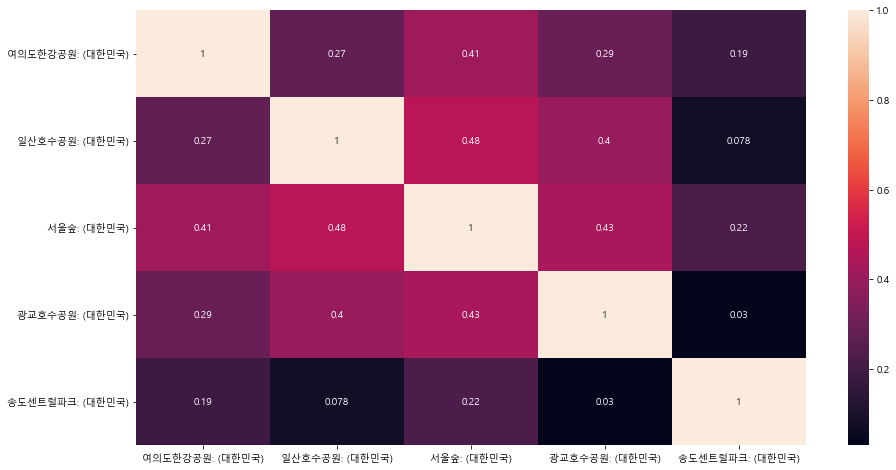

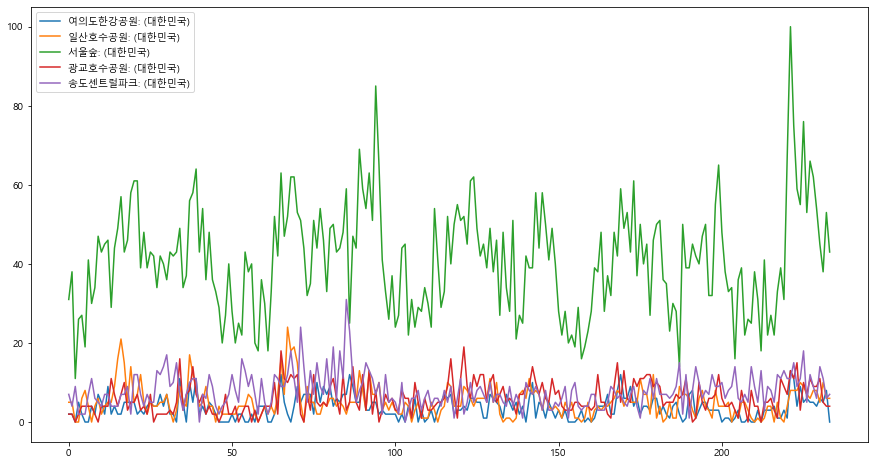

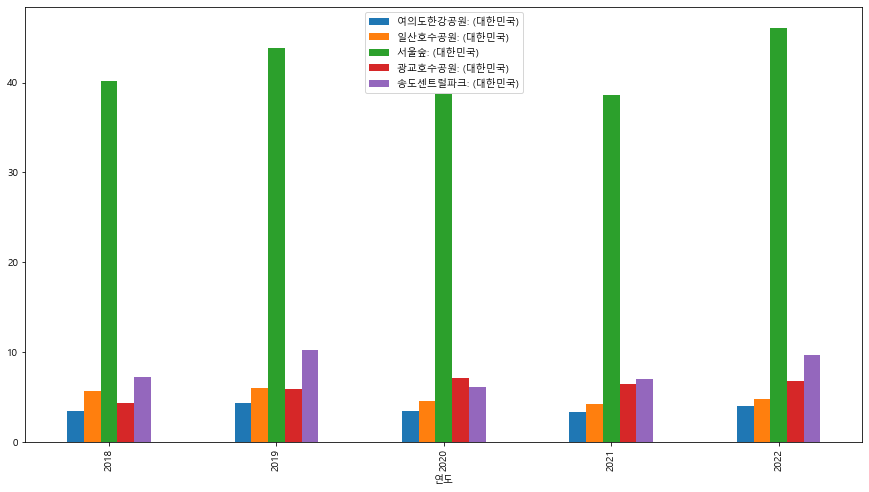

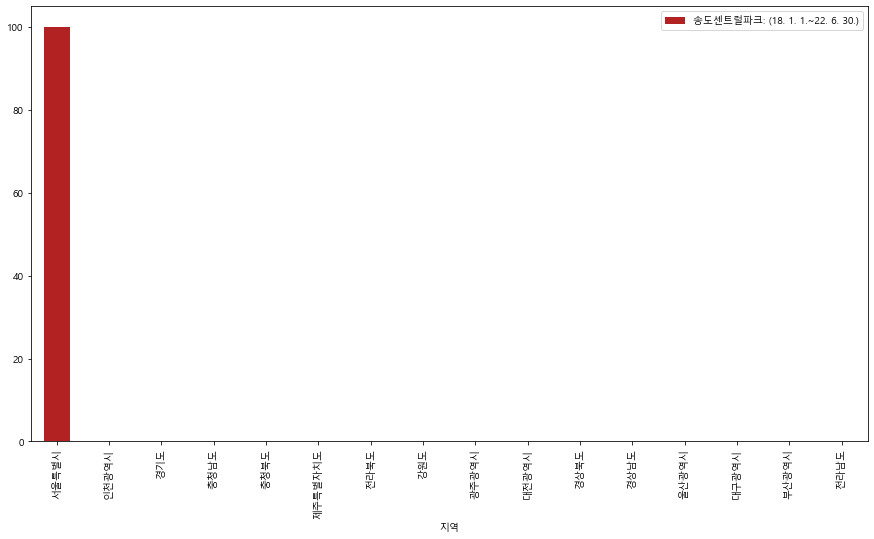

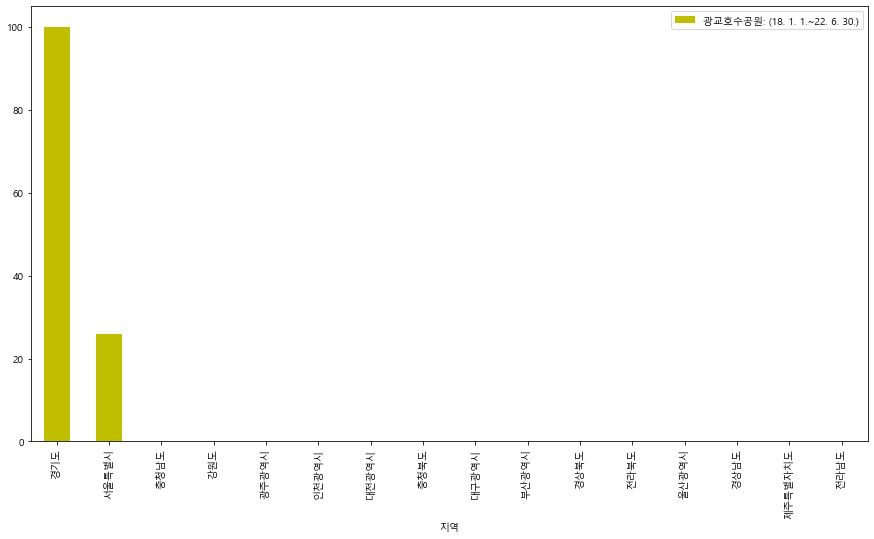

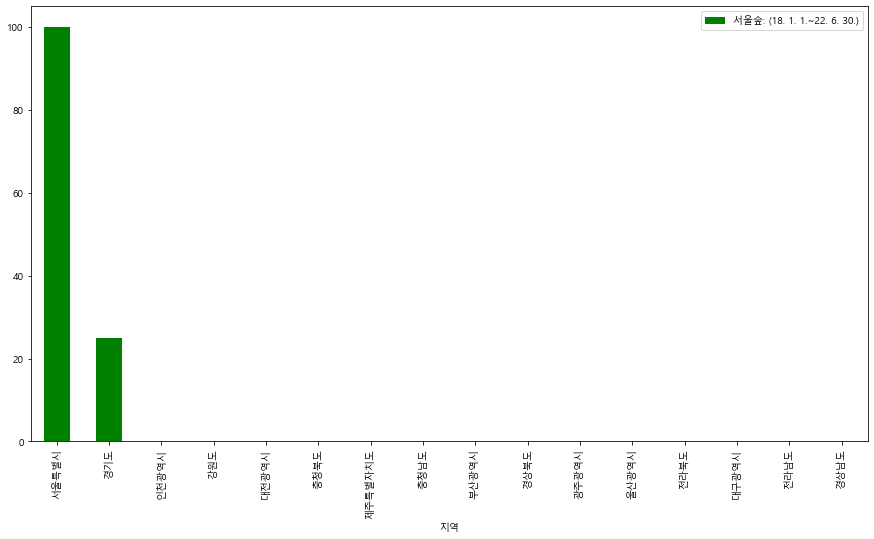

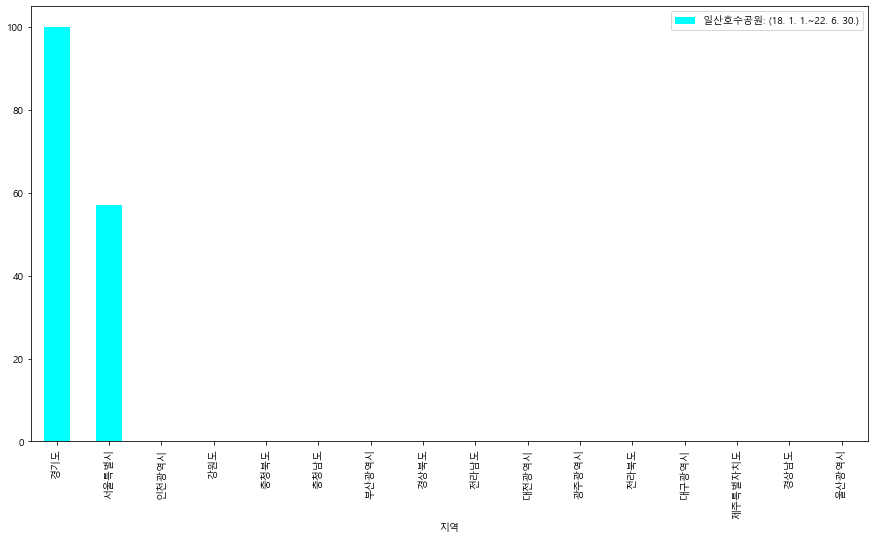

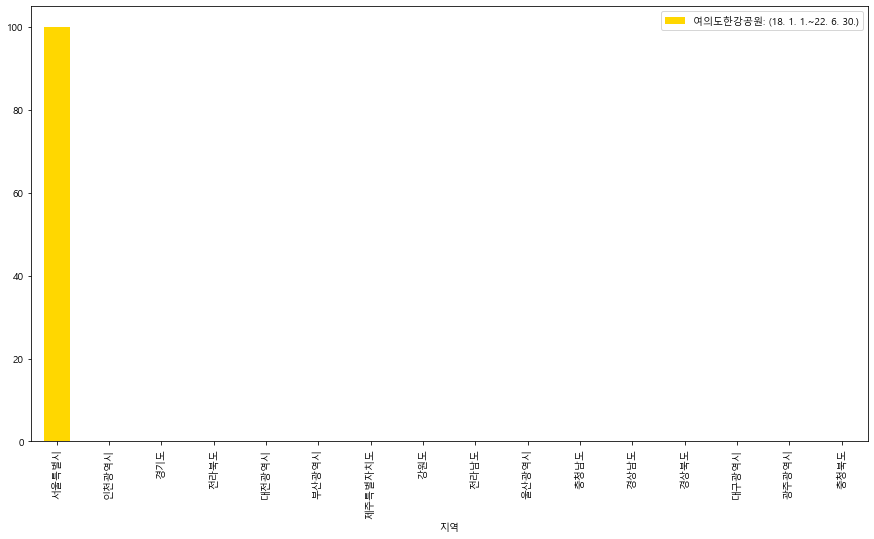

In [37]:
# 상위 요소 중에 6 항목을 골라서 구글 트렌드 비교

# 백화점
# make_manybar('outlet5')
# make_bar('outlet5')

# 자연경관
# make_manybar('nature')
# make_bar('nature')

# 시장
# make_manybar('market')
# make_bar('market')

# 공원
make_manybar('park')
make_bar('park')

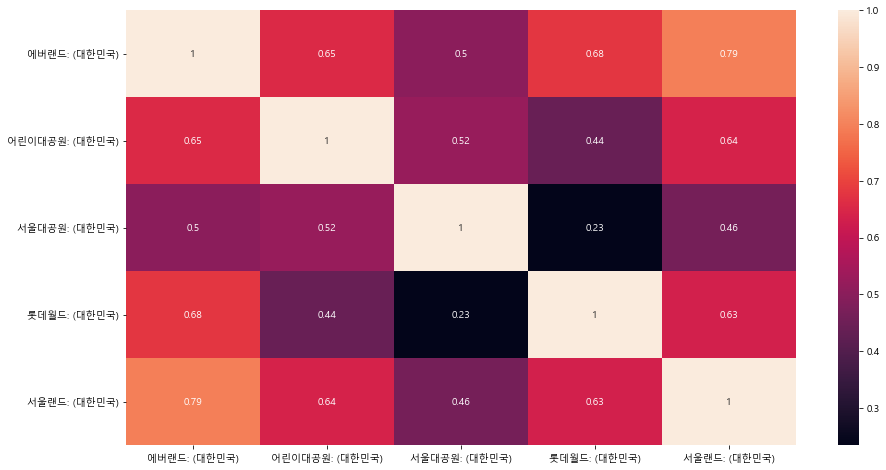

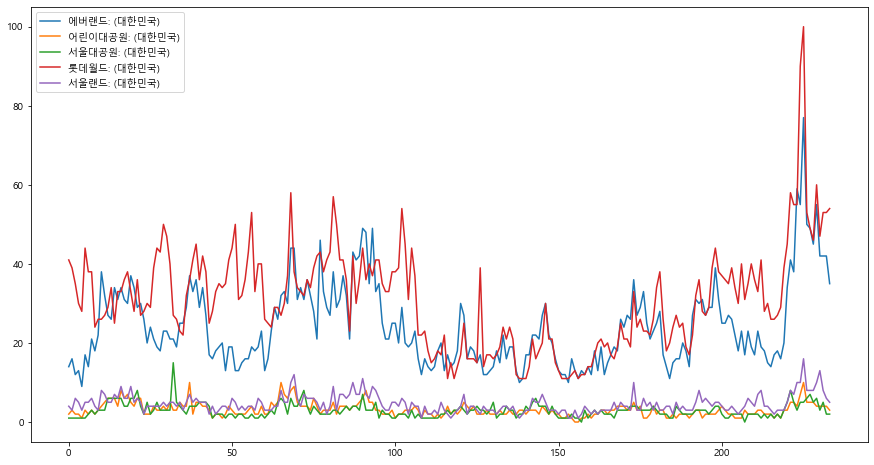

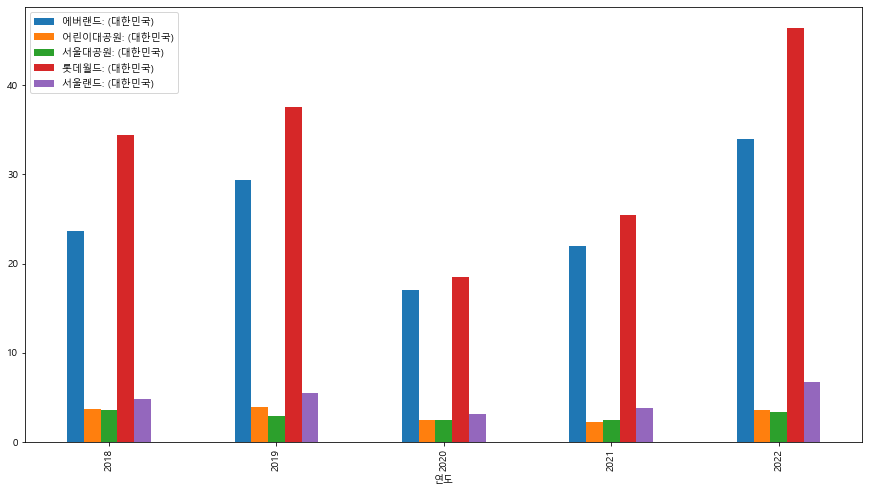

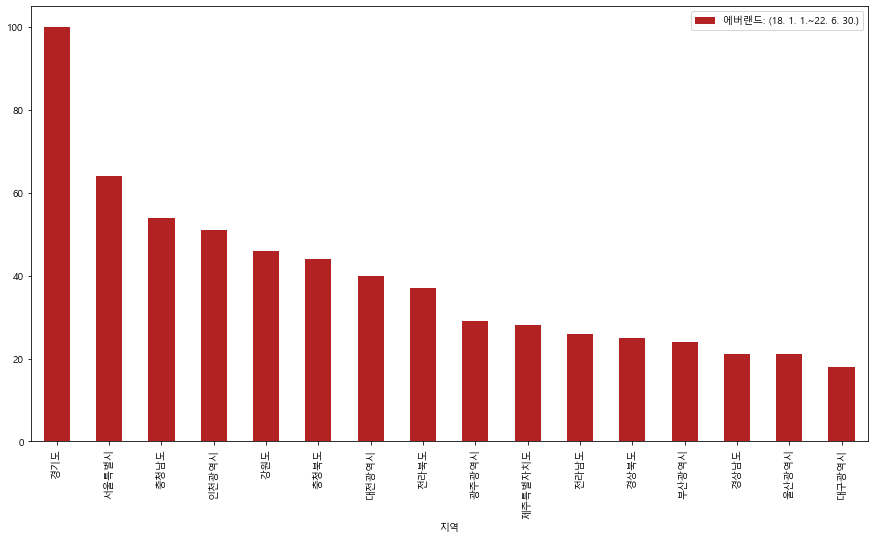

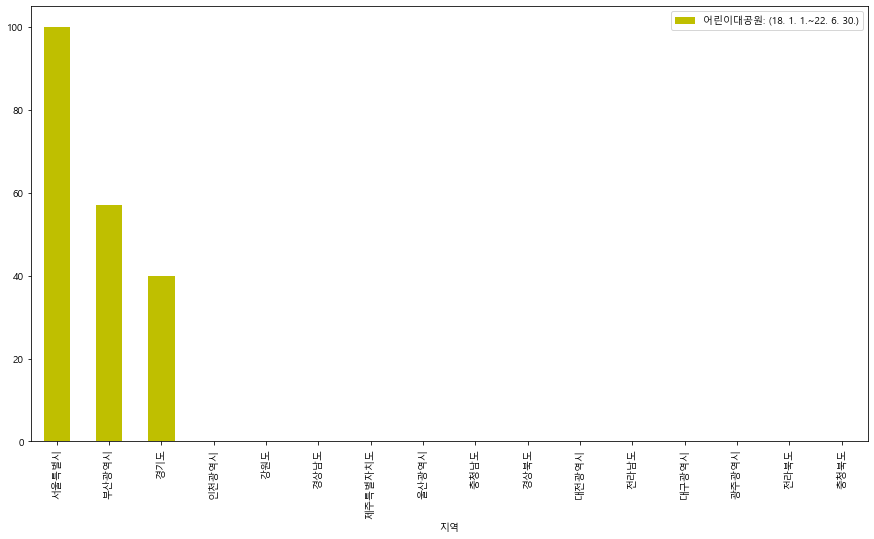

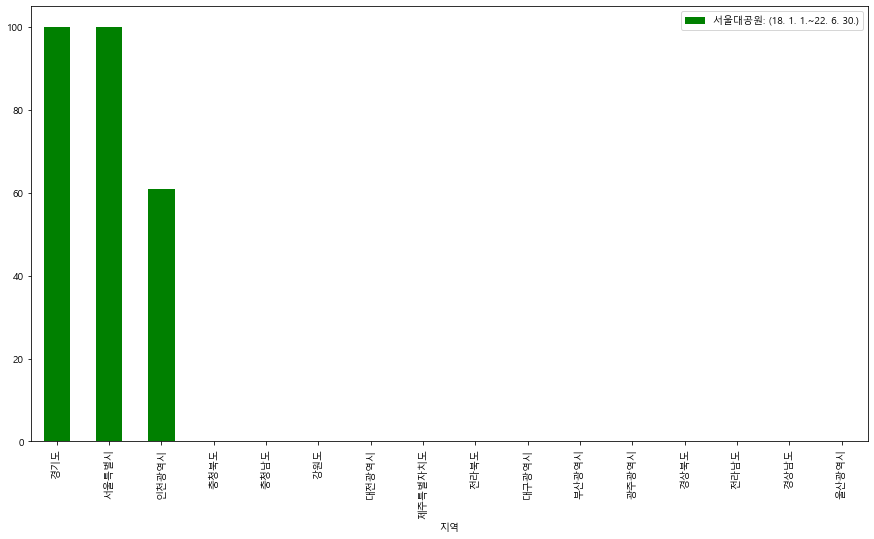

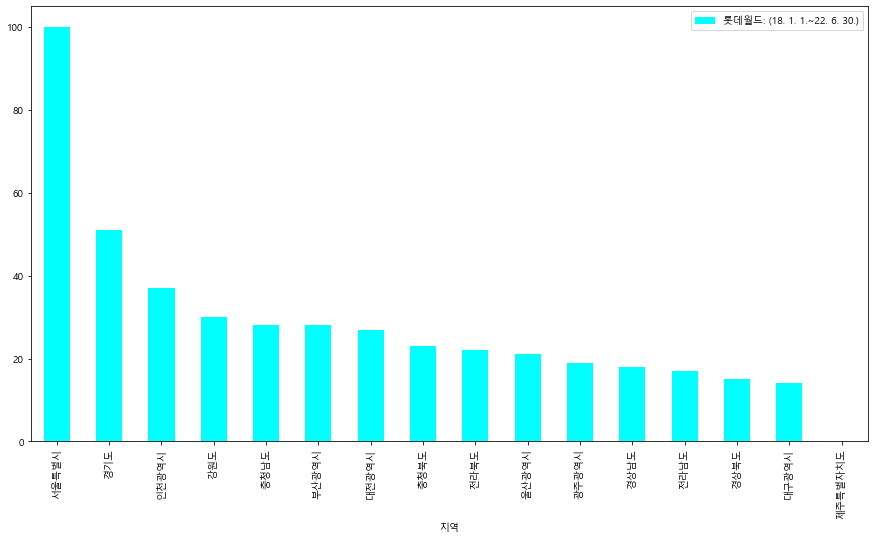

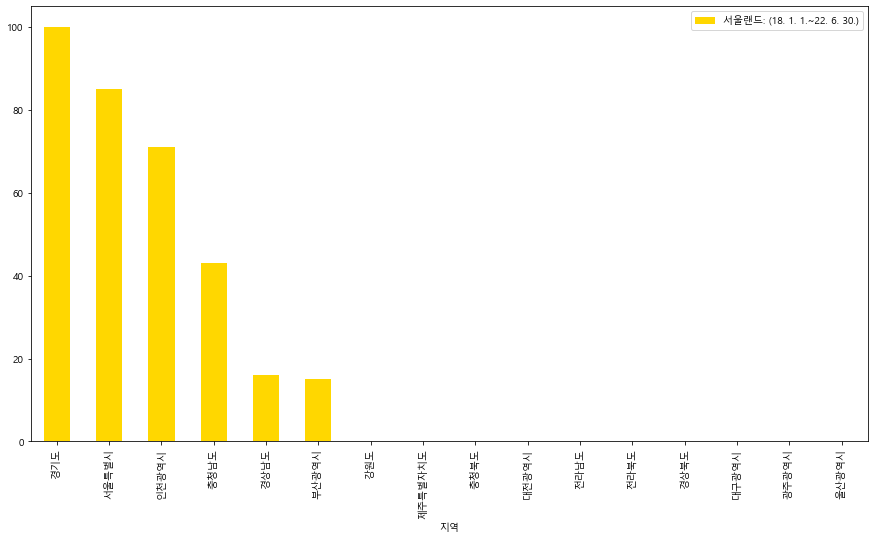

In [38]:
# 테마공원
make_manybar('themepark')
make_bar('themepark')

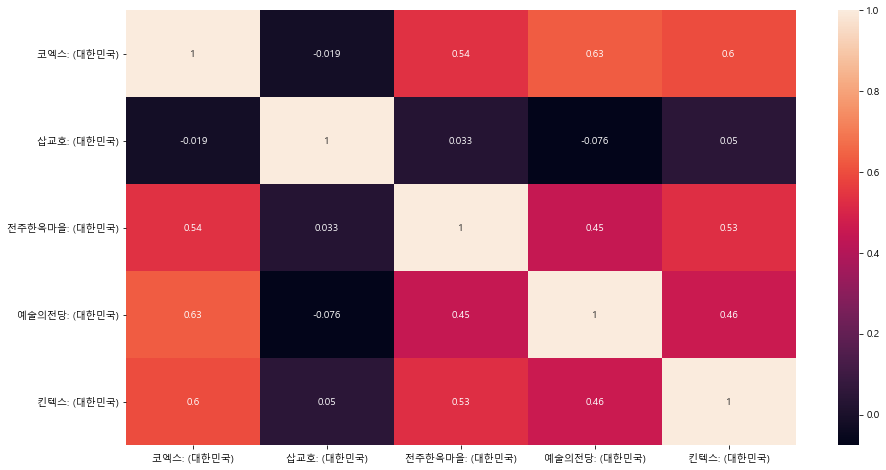

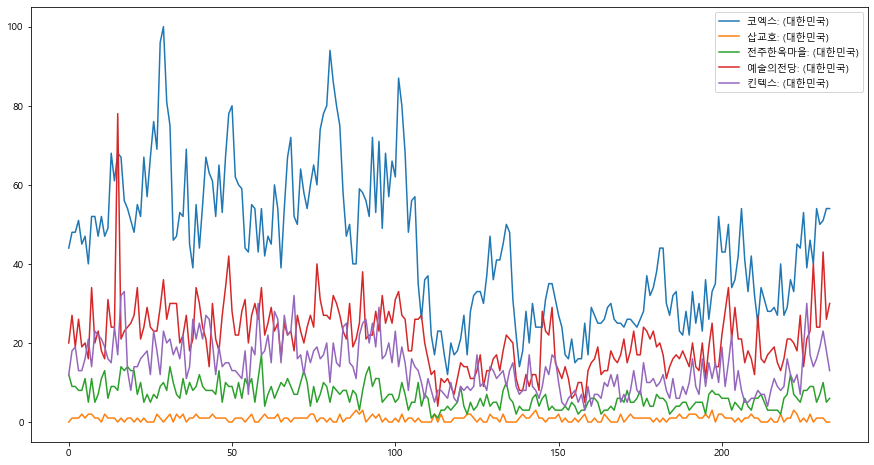

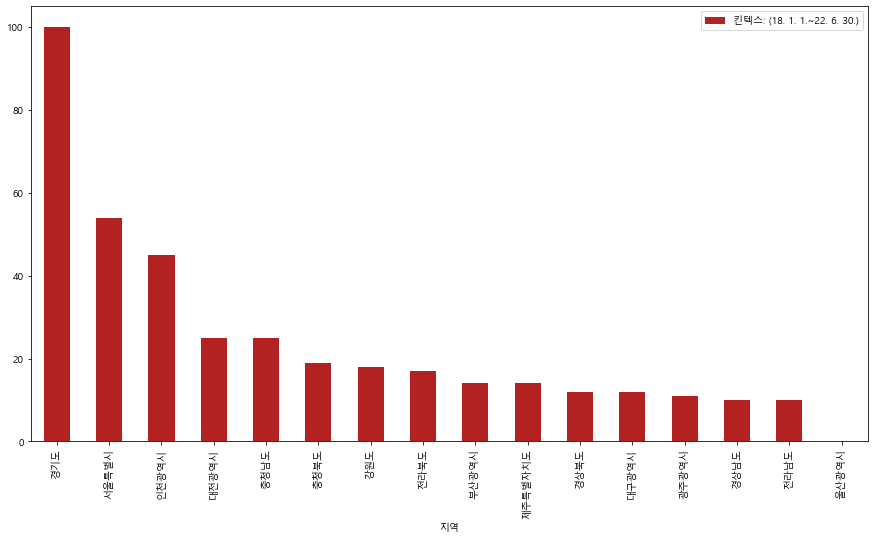

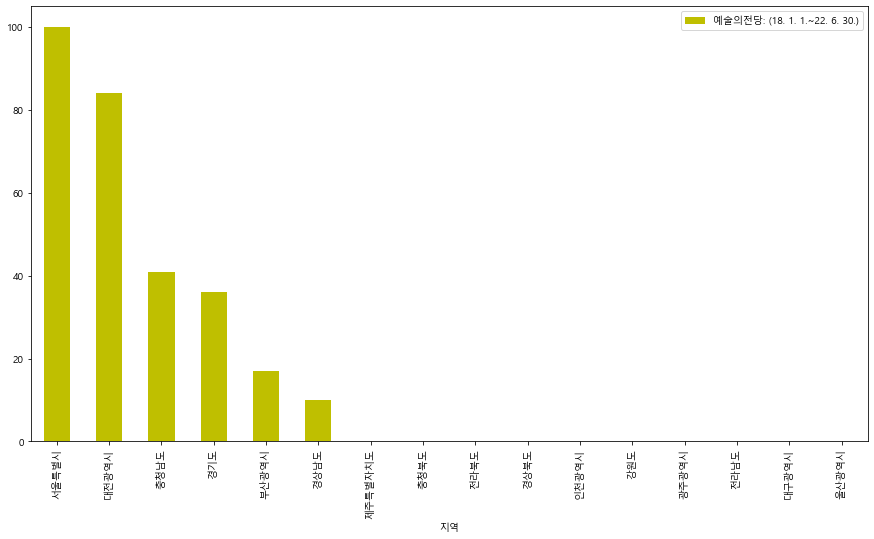

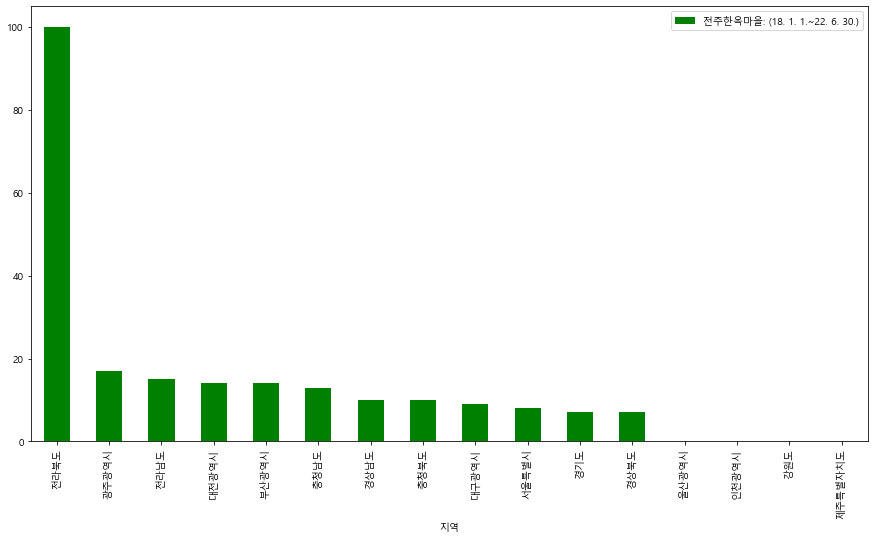

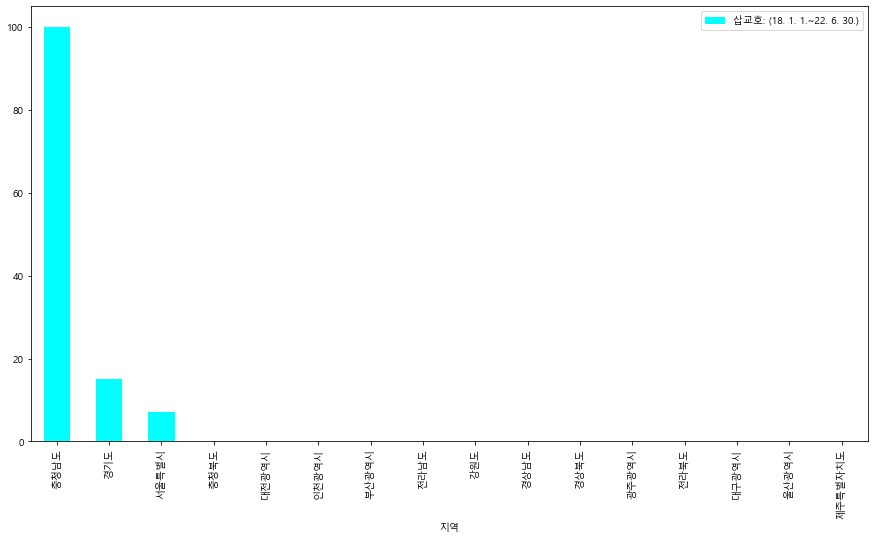

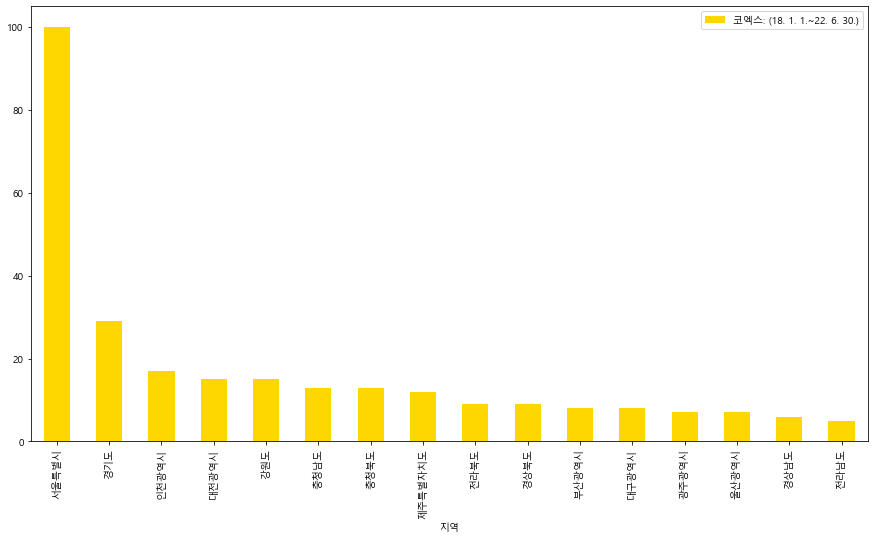

In [39]:

# 기타
make_heatmap('guitar')
make_bar('guitar')

#### 결론: 관광명소들의 검색량이 분석 이전에는 차이가 클 것이라 예상햇지만, 실제로는 코로나 이전에 비해서 코로나 이후에 근소하게 검색량이 줄었음을 알 수 있습니다. 생각보다 사람들의 관심은 줄지 않아서 검색량이 유지되는 것을 알 수 있습니다. 그리고 21년도 쯤부터 검색량이 다시 상승하는 것을 봤을때, 
##### 코로나에 대한 공포심이 덜해지고 확산세가 줄어들었다는 점이 반영되었다라고 추론할 수 있습니다. 